Let's implement the entire process using PyTorch. We'll load the MNIST dataset, train a fully connected neural network, and explain the predictions using both LIME and SHAP.

1. Load the MNIST Dataset and Train a Fully Connected Neural Network
Step 1: Load the MNIST Dataset

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders for batching
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 23467411.62it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 742230.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4917149.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1380473.10it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Step 2: Build a Fully Connected Neural Network


In [7]:
# Define the model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = NeuralNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.3904
Epoch [2/5], Loss: 0.1867
Epoch [3/5], Loss: 0.1364
Epoch [4/5], Loss: 0.1112
Epoch [5/5], Loss: 0.0940


2. Select Test Images and Use LIME to Explain Predictions


In [4]:
!pip install lime
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torch.autograd import Variable

# Function to predict using the PyTorch model
def predict(images):
    images = torch.Tensor(images).permute(0, 3, 1, 2)  # Convert images to PyTorch tensor
    images = images / 255.0  # Normalize
    outputs = model(images)
    return outputs.detach().numpy()

# Select test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
test_images = images[:5]
test_labels = labels[:5]

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain a single image
i = 0  # Index of the image to explain
image = test_images[i].numpy().transpose(1, 2, 0)
explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0, num_samples=1000)

# Visualize the LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME Explanation for Test Image {i}")
plt.show()



NameError: name 'test_loader' is not defined

3. Use SHAP to Explain Predictions


  0%|          | 0/5 [00:00<?, ?it/s]

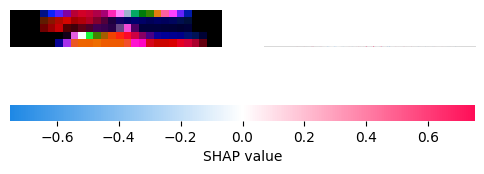

In [8]:
import shap

# Convert the model to a format SHAP can use
def pytorch_predict(data):
    with torch.no_grad():
        data = torch.tensor(data).float()
        data = data.view(-1, 28*28)
        return model(data).numpy()

# Select a few test images for SHAP
shap_test_images = images[:5].view(-1, 28*28).numpy()

# Create a SHAP explainer
explainer = shap.KernelExplainer(pytorch_predict, shap_test_images)

# Calculate SHAP values for one image
shap_values = explainer.shap_values(shap_test_images)

# Plot SHAP values
shap.image_plot(shap_values, shap_test_images.reshape(-1, 28, 28))
